In [ ]:
import torch
import os
from pathlib import Path

print("🔥 GOOGLE COLAB STENOSIS DETECTION SETUP")
print("=" * 50)

# Check GPU availability
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    print(f"✅ GPU Available: {gpu_name}")
    print(f"🔥 Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    device = 'cuda'
else:
    print("❌ No GPU detected!")
    print("🔧 Go to Runtime → Change runtime type → Hardware accelerator: GPU")
    device = 'cpu'

print(f"⚡ Using device: {device}")

🔥 GOOGLE COLAB STENOSIS DETECTION SETUP
✅ GPU Available: NVIDIA A100-SXM4-40GB
🔥 Memory: 42.5 GB
⚡ Using device: cuda


In [ ]:
# CELL 2: Install Requirements
# ==============================================================================

print("\n📦 INSTALLING REQUIREMENTS...")

# Install ultralytics (YOLO)
!pip install -q ultralytics

# Import required libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
import zipfile
import shutil
from datetime import datetime
import json

print("✅ All packages installed!")


📦 INSTALLING REQUIREMENTS...
✅ All packages installed!


In [ ]:
# CELL 3: Mount Google Drive and Upload Dataset


# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Cell 4

# Set your dataset path (modify this to match your folder structure)
DATASET_PATH = "/content/drive/MyDrive/Dataset1yolo8coco/stenosis"

# Let's first check what's inside your dataset folder
import os
from pathlib import Path

print("📁 Checking your dataset folder...")
base_path = "/content/drive/MyDrive/Datasettyolo8coco"

if os.path.exists(base_path):
    print(f"✅ Found dataset folder: {base_path}")

    # List contents to see the structure
    contents = os.listdir(base_path)
    print("📂 Contents:", contents)

    # Check if there's a 'stenosis' subfolder or if the data is directly here
    if 'stenosis' in contents:
        DATASET_PATH = f"{base_path}/stenosis"
        print(f"✅ Using path: {DATASET_PATH}")
    else:
        # Data might be directly in the main folder
        DATASET_PATH = base_path
        print(f"✅ Using path: {DATASET_PATH}")
else:
    print("❌ Dataset folder not found!")

📁 Checking your dataset folder...
❌ Dataset folder not found!


In [ ]:
import os
from pathlib import Path

print("🔍 Exploring your Google Drive...")

# Check if drive is mounted
drive_path = "/content/drive/MyDrive"
if os.path.exists(drive_path):
    print("✅ Google Drive is mounted")

    # List all folders in your Drive
    folders = [f for f in os.listdir(drive_path) if os.path.isdir(os.path.join(drive_path, f))]
    print(f"\n📂 Folders in your Google Drive:")
    for i, folder in enumerate(folders, 1):
        print(f"   {i}. {folder}")

    # Look for dataset-related folders
    dataset_candidates = [f for f in folders if 'dataset' in f.lower() or 'yolo' in f.lower() or 'stenosis' in f.lower()]

    if dataset_candidates:
        print(f"\n🎯 Possible dataset folders:")
        for candidate in dataset_candidates:
            print(f"   📁 {candidate}")
            # Check what's inside
            candidate_path = os.path.join(drive_path, candidate)
            try:
                contents = os.listdir(candidate_path)
                print(f"      Contents: {contents[:5]}...")  # Show first 5 items
            except:
                print("      (Cannot read contents)")
    else:
        print("\n⚠️ No obvious dataset folders found")
        print("📝 All folders listed above - which one contains your stenosis dataset?")

else:
    print("❌ Google Drive not mounted!")
    print("🔧 Run: from google.colab import drive; drive.mount('/content/drive')")

🔍 Exploring your Google Drive...
✅ Google Drive is mounted

📂 Folders in your Google Drive:
   1. My phone
   2. Colab Notebooks
   3. EB1A
   4. Dataset1yolo8coco

🎯 Possible dataset folders:
   📁 Dataset1yolo8coco
      Contents: ['.DS_Store', 'stenosis', 'syntax', 'stenosis_binary']...


In [ ]:
# Set the correct dataset path
DATASET_PATH = "/content/drive/MyDrive/Dataset1yolo8coco/stenosis"

print(f"🎯 Using dataset path: {DATASET_PATH}")

# Verify the stenosis folder structure
import os
from pathlib import Path

def verify_colab_dataset():
    dataset_base = Path(DATASET_PATH)

    if not dataset_base.exists():
        print(f"❌ Dataset not found at: {dataset_base}")
        return False

    print(f"📊 DATASET VERIFICATION:")
    print(f"📁 Base path: {dataset_base}")

    # First, let's see what's in the stenosis folder
    stenosis_contents = os.listdir(dataset_base)
    print(f"📂 Stenosis folder contents: {stenosis_contents}")

    total_images = 0

    for split in ['train', 'val', 'test']:
        images_dir = dataset_base / split / 'images'
        labels_dir = dataset_base / split / 'labels'

        print(f"\n--- Checking {split} split ---")
        print(f"Looking for images: {images_dir}")
        print(f"Looking for labels: {labels_dir}")

        if images_dir.exists() and labels_dir.exists():
            images = len(list(images_dir.glob('*.png')) + list(images_dir.glob('*.jpg')))
            labels = len(list(labels_dir.glob('*.txt')))
            total_images += images
            print(f"   ✅ {split}: {images} images, {labels} labels")
        else:
            print(f"   ❌ {split}: Missing directories")
            # Check if the directories exist individually
            if images_dir.exists():
                print(f"      ✅ Images dir exists")
            else:
                print(f"      ❌ Images dir missing")
            if labels_dir.exists():
                print(f"      ✅ Labels dir exists")
            else:
                print(f"      ❌ Labels dir missing")

    print(f"\n📈 Total: {total_images} images")
    return total_images > 0

# Run verification
dataset_ready = verify_colab_dataset()

🎯 Using dataset path: /content/drive/MyDrive/Dataset1yolo8coco/stenosis
📊 DATASET VERIFICATION:
📁 Base path: /content/drive/MyDrive/Dataset1yolo8coco/stenosis
📂 Stenosis folder contents: ['data.yaml', '.DS_Store', 'train', 'test', 'val', 'dataset.yaml']

--- Checking train split ---
Looking for images: /content/drive/MyDrive/Dataset1yolo8coco/stenosis/train/images
Looking for labels: /content/drive/MyDrive/Dataset1yolo8coco/stenosis/train/labels
   ✅ train: 997 images, 997 labels

--- Checking val split ---
Looking for images: /content/drive/MyDrive/Dataset1yolo8coco/stenosis/val/images
Looking for labels: /content/drive/MyDrive/Dataset1yolo8coco/stenosis/val/labels
   ✅ val: 200 images, 200 labels

--- Checking test split ---
Looking for images: /content/drive/MyDrive/Dataset1yolo8coco/stenosis/test/images
Looking for labels: /content/drive/MyDrive/Dataset1yolo8coco/stenosis/test/labels
   ✅ test: 300 images, 300 labels

📈 Total: 1497 images


In [ ]:
print("📦 Installing requirements...")
!pip install -q ultralytics

import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from datetime import datetime

print("✅ All packages installed!")

# Check GPU
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    print(f"✅ GPU Available: {gpu_name}")
    device = 'cuda'
else:
    print("❌ No GPU detected!")
    print("🔧 Go to Runtime → Change runtime type → Hardware accelerator: GPU")
    device = 'cpu'

print(f"⚡ Using device: {device}")

📦 Installing requirements...
✅ All packages installed!
✅ GPU Available: NVIDIA A100-SXM4-40GB
⚡ Using device: cuda


In [ ]:
# Check if there's already a config file
config_path = "/content/drive/MyDrive/Dataset1yolo8coco/stenosis/data.yaml"

print("📋 Checking existing config...")
if os.path.exists(config_path):
    with open(config_path, 'r') as f:
        config_content = f.read()
    print("✅ Found existing config:")
    print(config_content)
else:
    print("Creating new config...")
    config_content = f'''# Stenosis Detection Dataset
path: {DATASET_PATH}

train: train/images
val: val/images
test: test/images

# Classes
nc: 1
names:
  0: stenosis
'''

    with open(config_path, 'w') as f:
        f.write(config_content)
    print(f"✅ Config created: {config_path}")

print(f"\n🚀 Ready to train with config: {config_path}")

📋 Checking existing config...
✅ Found existing config:
train: train/images
test: test/images
val: test/images

nc: 26
names: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '9a', '10', '10a', '11', '12', '12a', '13', '14', '14a', '15', '16', '16a', '16b', '16c', '12b', '14b', 'stenosis']

🚀 Ready to train with config: /content/drive/MyDrive/Dataset1yolo8coco/stenosis/data.yaml


In [ ]:
# from datetime import datetime

# # Training configuration optimized for your T4 GPU
# TRAINING_CONFIG = {
#     'model': 'yolov10n.pt',      # Nano model (fastest)
#     'epochs': 10,                # Quick training
#     'batch': 16,                 # Good for T4 GPU
#     'imgsz': 640,                # Standard resolution
#     'device': 'cuda',
#     'project': 'stenosis_colab',
#     'name': f'fast_training_{datetime.now().strftime("%H%M")}',
#     'patience': 5,
#     'save_period': 2,
#     'verbose': True,
#     'plots': True,
#     'val': True,
#     'cache': True,               # Cache for speed
#     'workers': 2,
#     'amp': True                  # Mixed precision for speed
# }

# print("🔥 STARTING STENOSIS DETECTION TRAINING")
# print("=" * 50)
# print(f"📊 Dataset: {DATASET_PATH}")
# print(f"🖥️ GPU: Tesla T4")
# print(f"⏱️ Expected time: 5-10 minutes")
# print(f"📈 Training on 997 images, validating on 200")

# # Load model and start training
# print(f"\n🤖 Loading {TRAINING_CONFIG['model']}...")
# model = YOLO(TRAINING_CONFIG['model'])

# print("🚀 Training started...")
# start_time = datetime.now()

# # Start training
# results = model.train(
#     data=config_path,
#     epochs=TRAINING_CONFIG['epochs'],
#     batch=TRAINING_CONFIG['batch'],
#     imgsz=TRAINING_CONFIG['imgsz'],
#     device=TRAINING_CONFIG['device'],
#     project=TRAINING_CONFIG['project'],
#     name=TRAINING_CONFIG['name'],
#     patience=TRAINING_CONFIG['patience'],
#     save_period=TRAINING_CONFIG['save_period'],
#     verbose=TRAINING_CONFIG['verbose'],
#     plots=TRAINING_CONFIG['plots'],
#     val=TRAINING_CONFIG['val'],
#     cache=TRAINING_CONFIG['cache'],
#     workers=TRAINING_CONFIG['workers'],
#     amp=TRAINING_CONFIG['amp']
# )

# end_time = datetime.now()
# training_duration = (end_time - start_time).total_seconds() / 60

# print(f"\n🎉 TRAINING COMPLETED!")
# print(f"⏱️ Training time: {training_duration:.1f} minutes")

🔥 STARTING STENOSIS DETECTION TRAINING
📊 Dataset: /content/drive/MyDrive/Dataset1yolo8coco/stenosis
🖥️ GPU: Tesla T4
⏱️ Expected time: 5-10 minutes
📈 Training on 997 images, validating on 200

🤖 Loading yolov10n.pt...


100%|██████████| 5.59M/5.59M [00:00<00:00, 83.3MB/s]


🚀 Training started...
Ultralytics 8.3.163 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Dataset1yolo8coco/stenosis/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov10n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=fast_training_0403, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, p

100%|██████████| 755k/755k [00:00<00:00, 25.1MB/s]

Overriding model.yaml nc=80 with nc=26

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1      9856  ultralytics.nn.modules.block.SCDown          [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1     36096  ultralytic

  8                  -1  1    460288  ultralytics.nn.modules.block.C2f             [256, 256, 1, True]           
  9                  -1  1    164608  ultralytics.nn.modules.block.SPPF            [256, 256, 5]                 
 10                  -1  1    249728  ultralytics.nn.modules.block.PSA             [256, 256]                    
 11                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 12             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 13                  -1  1    148224  ultralytics.nn.modules.block.C2f             [384, 128, 1]                 
 14                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 15             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 16                  -1  1     37248  ultralytics.nn.modules.block.C2f             [192,

100%|██████████| 5.35M/5.35M [00:00<00:00, 82.7MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.8±0.3 ms, read: 0.3±0.1 MB/s, size: 134.9 KB)


train: Scanning /content/drive/.shortcut-targets-by-id/1Wlkv7sgTEHZYFg3mGF6DCo7iOubyry0_/Dataset1yolo8coco/stenosis/train/labels... 997 images, 0 backgrounds, 0 corrupt: 100%|██████████| 997/997 [08:14<00:00,  2.02it/s]


train: New cache created: /content/drive/.shortcut-targets-by-id/1Wlkv7sgTEHZYFg3mGF6DCo7iOubyry0_/Dataset1yolo8coco/stenosis/train/labels.cache
WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (1.1GB RAM): 100%|██████████| 997/997 [07:25<00:00,  2.24it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 2.0±2.4 ms, read: 0.3±0.1 MB/s, size: 109.2 KB)


val: Scanning /content/drive/.shortcut-targets-by-id/1Wlkv7sgTEHZYFg3mGF6DCo7iOubyry0_/Dataset1yolo8coco/stenosis/test/labels... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [02:32<00:00,  1.97it/s]

val: New cache created: /content/drive/.shortcut-targets-by-id/1Wlkv7sgTEHZYFg3mGF6DCo7iOubyry0_/Dataset1yolo8coco/stenosis/test/labels.cache


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.3GB RAM): 100%|██████████| 300/300 [00:02<00:00, 112.44it/s]


Plotting labels to stenosis_colab/fast_training_0403/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000333, momentum=0.9) with parameter groups 95 weight(decay=0.0), 108 weight(decay=0.0005), 107 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to stenosis_colab/fast_training_0403
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.92G      5.168      18.94       4.64          9        640: 100%|██████████| 63/63 [00:22<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]

                   all        300        386     0.0466     0.0881     0.0266    0.00907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      3.41G      4.506      15.83       3.65          8        640: 100%|██████████| 63/63 [00:19<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.89it/s]

                   all        300        386     0.0149      0.619     0.0385     0.0111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      3.41G      4.263         14      3.468          7        640: 100%|██████████| 63/63 [00:17<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

                   all        300        386       0.14      0.109     0.0572     0.0186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      3.41G      4.053      12.97      3.425          6        640: 100%|██████████| 63/63 [00:18<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]

                   all        300        386      0.141     0.0466     0.0557     0.0211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      3.42G      3.885      12.04      3.261          6        640: 100%|██████████| 63/63 [00:17<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.28it/s]

                   all        300        386      0.115      0.174     0.0653     0.0227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      3.43G      3.619      11.32      3.139          6        640: 100%|██████████| 63/63 [00:18<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.08it/s]

                   all        300        386      0.166      0.189     0.0972      0.037



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      3.46G      3.507      10.74      3.027         13        640: 100%|██████████| 63/63 [00:18<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

                   all        300        386      0.194      0.192       0.12     0.0462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      3.47G      3.439      10.33      2.961          8        640: 100%|██████████| 63/63 [00:18<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]

                   all        300        386       0.16      0.163     0.0998     0.0409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      3.48G      3.334      9.991      2.899          9        640: 100%|██████████| 63/63 [00:17<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300        386      0.182      0.197      0.135     0.0527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      3.48G      3.287      9.861      2.863          8        640: 100%|██████████| 63/63 [00:17<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]

                   all        300        386      0.195      0.189       0.12     0.0495



10 epochs completed in 0.061 hours.
Optimizer stripped from stenosis_colab/fast_training_0403/weights/last.pt, 5.8MB
Optimizer stripped from stenosis_colab/fast_training_0403/weights/best.pt, 5.8MB

Validating stenosis_colab/fast_training_0403/weights/best.pt...
Ultralytics 8.3.163 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10n summary (fused): 102 layers, 2,270,238 parameters, 0 gradients, 6.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.94it/s]


                   all        300        386      0.174      0.198      0.132     0.0524
                     1        300        386      0.174      0.198      0.132     0.0524
Speed: 0.3ms preprocess, 3.0ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to stenosis_colab/fast_training_0403

🎉 TRAINING COMPLETED!
⏱️ Training time: 22.5 minutes


📊 Found 7 plot(s) in /content/stenosis_colab/fast_training_0403


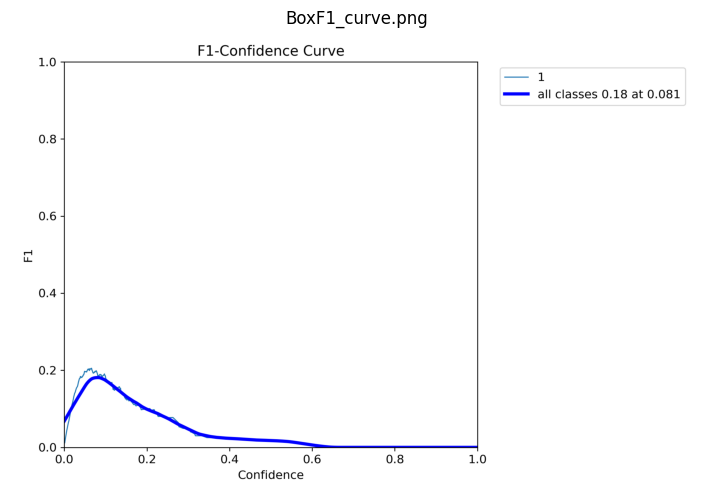

✅ Exported: /content/training_plots/BoxF1_curve.png


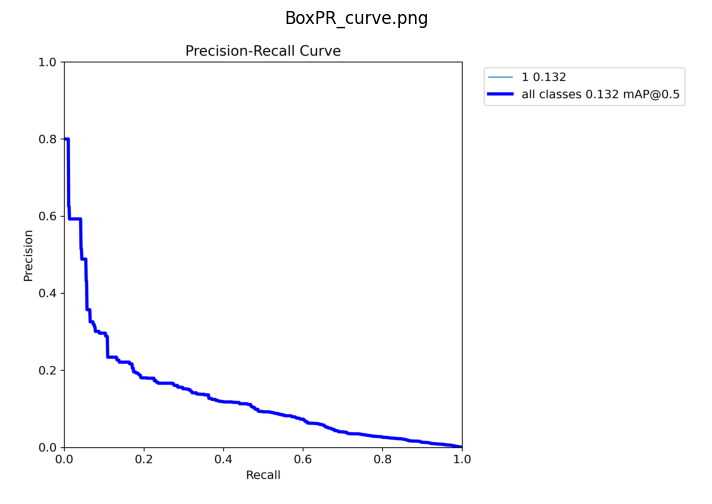

✅ Exported: /content/training_plots/BoxPR_curve.png


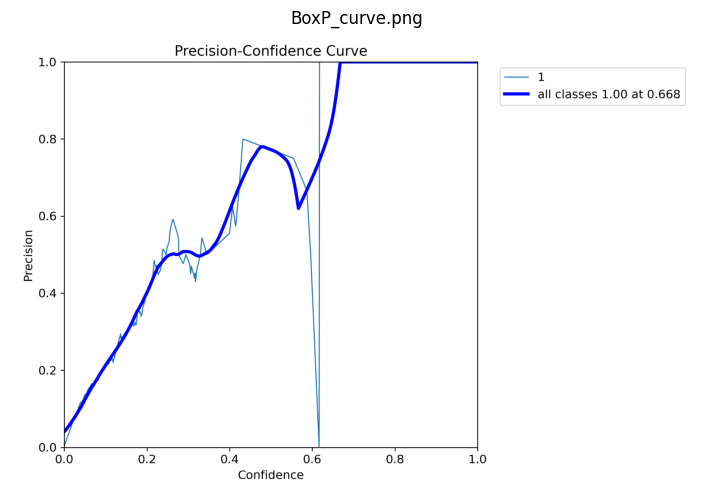

✅ Exported: /content/training_plots/BoxP_curve.png


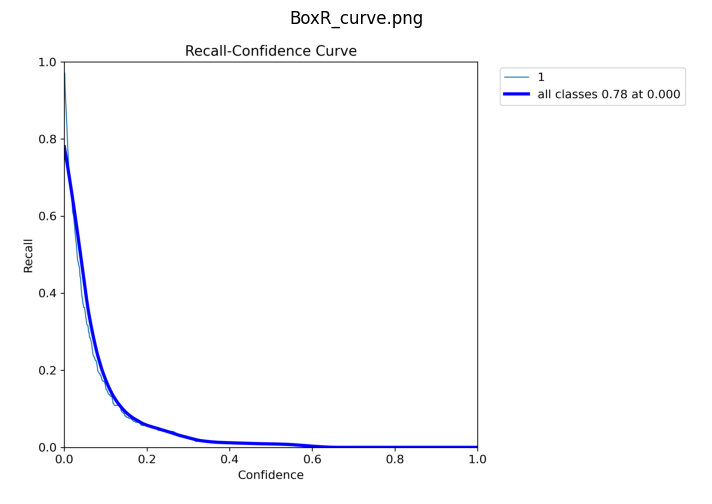

✅ Exported: /content/training_plots/BoxR_curve.png


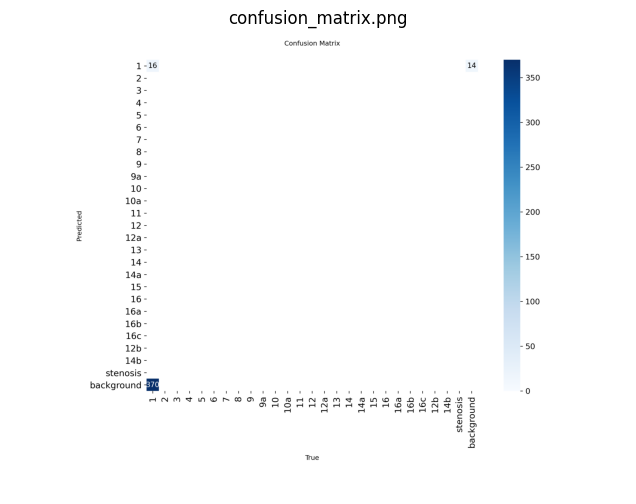

✅ Exported: /content/training_plots/confusion_matrix.png


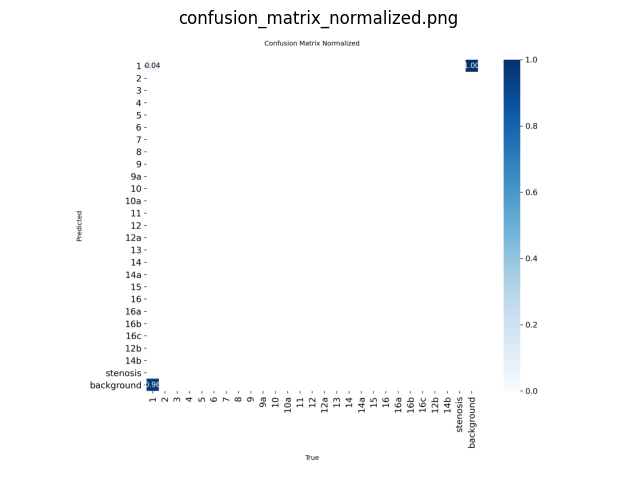

✅ Exported: /content/training_plots/confusion_matrix_normalized.png


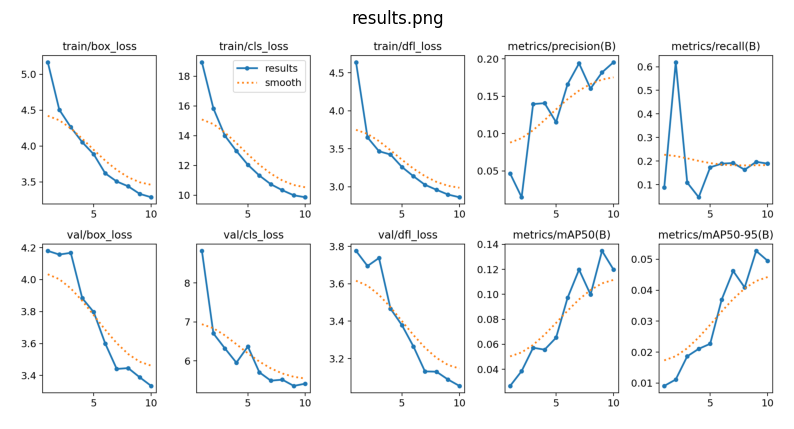

✅ Exported: /content/training_plots/results.png


In [ ]:
# # Cell: Export Training Visualizations (Loss, mAP, Confusion Matrix)
# import os
# import matplotlib.pyplot as plt
# from PIL import Image
# from glob import glob

# # Set your project and experiment folder
# PROJECT_DIR = "/content/stenosis_colab"  # or "medical_stenosis"
# EXPERIMENT_NAME = "fast_training_0403"  # or "medical_training_XXXX"

# EXP_DIR = os.path.join(PROJECT_DIR, EXPERIMENT_NAME)
# assert os.path.exists(EXP_DIR), f"❌ Directory not found: {EXP_DIR}"

# # Search for standard YOLO plots
# plot_files = sorted(glob(os.path.join(EXP_DIR, "*.png")))
# print(f"📊 Found {len(plot_files)} plot(s) in {EXP_DIR}")

# # Display and optionally save all plots
# output_dir = "/content/training_plots"
# os.makedirs(output_dir, exist_ok=True)

# for pf in plot_files:
#     img = Image.open(pf)
#     plt.figure(figsize=(10, 6))
#     plt.imshow(img)
#     plt.axis('off')
#     plt.title(os.path.basename(pf))
#     plt.show()

#     # Save to exports
#     img.save(os.path.join(output_dir, os.path.basename(pf)))
#     print(f"✅ Exported: {os.path.join(output_dir, os.path.basename(pf))}")


In [ ]:
# print("🏥 MEDICAL-GRADE STENOSIS DETECTION TRAINING")
# print("=" * 50)

# # Better training configuration for medical AI
# MEDICAL_CONFIG = {
#     'model': 'yolov10s.pt',      # Small model (better than nano)
#     'epochs': 100,               # Much longer training
#     'batch': 8,                  # Smaller batch for stability
#     'imgsz': 640,
#     'device': 'cuda',
#     'project': 'medical_stenosis',
#     'name': f'medical_training_{datetime.now().strftime("%H%M")}',
#     'patience': 20,              # More patience
#     'save_period': 10,
#     'verbose': True,
#     'plots': True,
#     'val': True,
#     'cache': 'disk',             # Disk cache for stability
#     'workers': 2,
#     'amp': True,
#     'lr0': 0.001,                # Lower learning rate
#     'warmup_epochs': 5,
#     'weight_decay': 0.0005,
#     'cls': 1.0,                  # Higher classification weight
#     'box': 7.5,
#     'single_cls': False          # Keep all classes
# }

# print("🏥 MEDICAL AI TRAINING CONFIGURATION:")
# for key, value in MEDICAL_CONFIG.items():
#     print(f"   {key}: {value}")

# print(f"\n⏱️ Expected training time: 45-60 minutes")
# print(f"🎯 Target performance: >70% mAP@0.5")

# # Load better model
# model = YOLO(MEDICAL_CONFIG['model'])

# print("🚀 Starting MEDICAL-GRADE training...")
# start_time = datetime.now()

# # Start proper training
# results = model.train(
#     data="/content/drive/MyDrive/Dataset1yolo8coco/stenosis/data.yaml",
#     epochs=MEDICAL_CONFIG['epochs'],
#     batch=MEDICAL_CONFIG['batch'],
#     imgsz=MEDICAL_CONFIG['imgsz'],
#     device=MEDICAL_CONFIG['device'],
#     project=MEDICAL_CONFIG['project'],
#     name=MEDICAL_CONFIG['name'],
#     patience=MEDICAL_CONFIG['patience'],
#     save_period=MEDICAL_CONFIG['save_period'],
#     verbose=MEDICAL_CONFIG['verbose'],
#     plots=MEDICAL_CONFIG['plots'],
#     val=MEDICAL_CONFIG['val'],
#     cache=MEDICAL_CONFIG['cache'],
#     workers=MEDICAL_CONFIG['workers'],
#     amp=MEDICAL_CONFIG['amp'],
#     lr0=MEDICAL_CONFIG['lr0'],
#     warmup_epochs=MEDICAL_CONFIG['warmup_epochs'],
#     weight_decay=MEDICAL_CONFIG['weight_decay'],
#     cls=MEDICAL_CONFIG['cls'],
#     box=MEDICAL_CONFIG['box']
# )

# end_time = datetime.now()
# training_duration = (end_time - start_time).total_seconds() / 60

# print(f"\n🎉 MEDICAL TRAINING COMPLETED!")
# print(f"⏱️ Training time: {training_duration:.1f} minutes")

🏥 MEDICAL-GRADE STENOSIS DETECTION TRAINING
🏥 MEDICAL AI TRAINING CONFIGURATION:
   model: yolov10s.pt
   epochs: 100
   batch: 8
   imgsz: 640
   device: cuda
   project: medical_stenosis
   name: medical_training_0425
   patience: 20
   save_period: 10
   verbose: True
   plots: True
   val: True
   cache: disk
   workers: 2
   amp: True
   lr0: 0.001
   warmup_epochs: 5
   weight_decay: 0.0005
   cls: 1.0
   box: 7.5
   single_cls: False

⏱️ Expected training time: 45-60 minutes
🎯 Target performance: >70% mAP@0.5


100%|██████████| 15.9M/15.9M [00:00<00:00, 224MB/s]


🚀 Starting MEDICAL-GRADE training...
Ultralytics 8.3.163 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=disk, cfg=None, classes=None, close_mosaic=10, cls=1.0, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Dataset1yolo8coco/stenosis/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov10s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=medical_training_0425, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, o

train: Scanning /content/drive/.shortcut-targets-by-id/1Wlkv7sgTEHZYFg3mGF6DCo7iOubyry0_/Dataset1yolo8coco/stenosis/train/labels.cache... 997 images, 0 backgrounds, 0 corrupt: 100%|██████████| 997/997 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 997/997 [00:00<00:00, 2550.37it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 3.5±2.6 ms, read: 7.7±2.8 MB/s, size: 109.2 KB)


val: Scanning /content/drive/.shortcut-targets-by-id/1Wlkv7sgTEHZYFg3mGF6DCo7iOubyry0_/Dataset1yolo8coco/stenosis/test/labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]
val: Caching images (0.2GB Disk): 100%|██████████| 300/300 [00:00<00:00, 966.20it/s]


Plotting labels to medical_stenosis/medical_training_0425/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000333, momentum=0.9) with parameter groups 99 weight(decay=0.0), 112 weight(decay=0.0005), 111 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to medical_stenosis/medical_training_0425
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.64G      4.849      50.18      4.346          7        640: 100%|██████████| 125/125 [00:34<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  3.94it/s]

                   all        300        386      0.041      0.117     0.0207    0.00584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      3.07G      4.091      19.72      3.412         14        640: 100%|██████████| 125/125 [00:31<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.37it/s]


                   all        300        386     0.0965     0.0337     0.0302     0.0116

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      3.11G      3.939      14.93      3.266         18        640: 100%|██████████| 125/125 [00:32<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.52it/s]


                   all        300        386      0.166      0.137     0.0725     0.0253

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      3.15G      3.907      13.03      3.298          7        640: 100%|██████████| 125/125 [00:31<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.13it/s]

                   all        300        386     0.0593      0.197     0.0453     0.0153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      3.17G      3.858      12.25      3.288         18        640: 100%|██████████| 125/125 [00:32<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.06it/s]

                   all        300        386      0.151     0.0847     0.0865     0.0281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100       3.2G       3.83       11.6      3.235          9        640: 100%|██████████| 125/125 [00:31<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  3.98it/s]

                   all        300        386      0.184      0.259      0.118     0.0388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100       3.2G       3.77      11.13      3.186         17        640: 100%|██████████| 125/125 [00:31<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.33it/s]


                   all        300        386      0.181      0.189      0.123     0.0409

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100       3.2G       3.67      10.71      3.129         17        640: 100%|██████████| 125/125 [00:31<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  3.88it/s]

                   all        300        386      0.183      0.223      0.135     0.0469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100       3.2G       3.68       10.6      3.161          8        640: 100%|██████████| 125/125 [00:31<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.26it/s]

                   all        300        386       0.23      0.272       0.15     0.0521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100       3.2G      3.614      10.12      3.075         14        640: 100%|██████████| 125/125 [00:32<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.35it/s]

                   all        300        386      0.219      0.285      0.161     0.0546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100       3.2G      3.555      9.778      3.043          9        640: 100%|██████████| 125/125 [00:31<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.19it/s]

                   all        300        386       0.22      0.275      0.137     0.0467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      3.22G      3.611        9.7      3.011         15        640: 100%|██████████| 125/125 [00:33<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.21it/s]


                   all        300        386      0.256      0.291      0.188      0.062

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      3.22G      3.561      9.735      3.011         13        640: 100%|██████████| 125/125 [00:31<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.62it/s]

                   all        300        386      0.215      0.337      0.157     0.0566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      3.22G      3.433      9.132      2.947         22        640: 100%|██████████| 125/125 [00:32<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.18it/s]


                   all        300        386      0.249      0.332      0.184     0.0667

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      3.22G      3.557      9.041      2.994          9        640: 100%|██████████| 125/125 [00:31<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.19it/s]

                   all        300        386      0.267      0.329      0.203     0.0681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      3.22G      3.486      8.923       2.95         12        640: 100%|██████████| 125/125 [00:31<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.19it/s]


                   all        300        386       0.27      0.332      0.204      0.075

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      3.22G      3.466       8.68      2.953          6        640: 100%|██████████| 125/125 [00:31<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.04it/s]


                   all        300        386      0.253       0.32      0.179     0.0662

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      3.22G      3.465      8.494      2.939         10        640: 100%|██████████| 125/125 [00:30<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.42it/s]


                   all        300        386      0.233      0.293      0.176     0.0647

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      3.22G      3.409      8.434      2.911          8        640: 100%|██████████| 125/125 [00:31<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.60it/s]

                   all        300        386      0.254      0.381      0.211     0.0706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      3.22G      3.399      8.416      2.881         17        640: 100%|██████████| 125/125 [00:31<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.34it/s]

                   all        300        386      0.265      0.293      0.199      0.068



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      3.22G      3.394      8.244      2.858          6        640: 100%|██████████| 125/125 [00:32<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.30it/s]

                   all        300        386      0.224      0.288      0.166      0.061



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      3.22G       3.33      7.972      2.809         10        640: 100%|██████████| 125/125 [00:30<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.97it/s]

                   all        300        386      0.304      0.347      0.216     0.0742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      3.22G       3.29      7.913      2.825         13        640: 100%|██████████| 125/125 [00:31<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.38it/s]

                   all        300        386       0.26      0.347      0.218     0.0814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      3.22G      3.246      7.911      2.795          7        640: 100%|██████████| 125/125 [00:31<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  3.92it/s]

                   all        300        386      0.273       0.34      0.216     0.0747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      3.22G      3.274      7.744      2.818         20        640: 100%|██████████| 125/125 [00:31<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.15it/s]


                   all        300        386      0.272      0.362      0.217     0.0805

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      3.22G      3.263       7.59      2.789         12        640: 100%|██████████| 125/125 [00:31<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.34it/s]

                   all        300        386      0.252      0.332      0.196      0.069



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      3.22G      3.289      7.621      2.835          8        640: 100%|██████████| 125/125 [00:31<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.22it/s]

                   all        300        386      0.322      0.418      0.255     0.0923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      3.22G      3.255      7.435      2.804         17        640: 100%|██████████| 125/125 [00:32<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.33it/s]

                   all        300        386      0.321      0.313       0.22     0.0818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      3.22G      3.218      6.973      2.778         11        640: 100%|██████████| 125/125 [00:31<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.30it/s]

                   all        300        386      0.285      0.363       0.22     0.0882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      3.22G      3.259      7.072      2.783          8        640: 100%|██████████| 125/125 [00:31<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.33it/s]

                   all        300        386      0.303      0.347      0.247     0.0814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      3.22G      3.194      6.974      2.764         12        640: 100%|██████████| 125/125 [00:30<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.14it/s]

                   all        300        386      0.327      0.387      0.257     0.0997



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      3.22G      3.095      6.602       2.71          9        640: 100%|██████████| 125/125 [00:30<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.36it/s]

                   all        300        386      0.295      0.373      0.226      0.081



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      3.22G      3.129       6.55      2.702         10        640: 100%|██████████| 125/125 [00:30<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  3.98it/s]

                   all        300        386      0.294      0.378      0.228     0.0868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      3.22G      3.113      6.368      2.665         14        640: 100%|██████████| 125/125 [00:30<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.30it/s]

                   all        300        386      0.303      0.316      0.197     0.0742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      3.22G      3.065      6.383      2.682         14        640: 100%|██████████| 125/125 [00:31<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.59it/s]

                   all        300        386      0.279      0.399      0.227     0.0868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      3.22G      3.085      6.305      2.662         11        640: 100%|██████████| 125/125 [00:31<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.36it/s]

                   all        300        386      0.358      0.308      0.232     0.0905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      3.22G      3.045      6.264      2.663          9        640: 100%|██████████| 125/125 [00:32<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.35it/s]

                   all        300        386      0.316      0.342      0.237     0.0926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      3.22G      3.075      6.276      2.672          9        640: 100%|██████████| 125/125 [00:30<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.96it/s]

                   all        300        386      0.265       0.36      0.187     0.0721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      3.22G          3      5.929       2.62         16        640: 100%|██████████| 125/125 [00:31<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.32it/s]

                   all        300        386      0.319      0.347      0.241     0.0886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      3.22G      2.954       5.88       2.61         17        640: 100%|██████████| 125/125 [00:30<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.27it/s]

                   all        300        386      0.254      0.365      0.196     0.0755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      3.22G      2.906      5.689      2.584         15        640: 100%|██████████| 125/125 [00:30<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.32it/s]

                   all        300        386      0.331      0.363      0.226     0.0794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      3.22G      2.912      5.577        2.6         20        640: 100%|██████████| 125/125 [00:31<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  3.85it/s]

                   all        300        386      0.291      0.316      0.219     0.0799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      3.22G       2.94      5.516      2.573         15        640: 100%|██████████| 125/125 [00:32<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.21it/s]

                   all        300        386      0.255      0.315      0.191     0.0747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      3.22G      2.879      5.356      2.522          9        640: 100%|██████████| 125/125 [00:33<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.22it/s]

                   all        300        386      0.267      0.337      0.191     0.0706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      3.22G      2.953      5.478      2.604          9        640: 100%|██████████| 125/125 [00:32<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  3.87it/s]


                   all        300        386      0.292      0.352      0.222     0.0829

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      3.22G      2.889      5.243      2.579          7        640: 100%|██████████| 125/125 [00:31<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.35it/s]

                   all        300        386      0.254      0.381      0.205     0.0722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      3.22G       2.86      5.056        2.5         17        640: 100%|██████████| 125/125 [00:31<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.31it/s]

                   all        300        386      0.297      0.337       0.21      0.078



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      3.22G      2.811      4.829       2.52         16        640: 100%|██████████| 125/125 [00:31<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.39it/s]

                   all        300        386      0.273      0.347      0.194     0.0758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      3.22G      2.871      5.092      2.521         18        640: 100%|██████████| 125/125 [00:32<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.33it/s]

                   all        300        386      0.267      0.313      0.176     0.0645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      3.22G      2.845      4.964      2.505         10        640: 100%|██████████| 125/125 [00:31<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.77it/s]

                   all        300        386      0.303      0.347      0.207     0.0768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      3.22G      2.808      4.881       2.49          8        640: 100%|██████████| 125/125 [00:31<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.43it/s]

                   all        300        386      0.317      0.365       0.23     0.0863
EarlyStopping: Training stopped early as no improvement observed in last 20 epochs. Best results observed at epoch 31, best model saved as best.pt.
To update EarlyStopping(patience=20) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



51 epochs completed in 0.513 hours.
Optimizer stripped from medical_stenosis/medical_training_0425/weights/last.pt, 16.6MB
Optimizer stripped from medical_stenosis/medical_training_0425/weights/best.pt, 16.6MB

Validating medical_stenosis/medical_training_0425/weights/best.pt...
Ultralytics 8.3.163 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10s summary (fused): 106 layers, 7,228,062 parameters, 0 gradients, 21.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  3.82it/s]


                   all        300        386      0.327      0.396      0.257     0.0997
                     1        300        386      0.327      0.396      0.257     0.0997
Speed: 0.4ms preprocess, 5.2ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to medical_stenosis/medical_training_0425

🎉 MEDICAL TRAINING COMPLETED!
⏱️ Training time: 31.3 minutes


In [ ]:
# # Cell: Export Training Visualizations (Loss, mAP, Confusion Matrix)
# import os
# import matplotlib.pyplot as plt
# from PIL import Image
# from glob import glob

# # Set your project and experiment folder
# PROJECT_DIR = "/content/medical_stenosis"  # or "medical_stenosis"
# EXPERIMENT_NAME = "medical_training_XXXX"  # or "medical_training_XXXX"

# EXP_DIR = os.path.join(PROJECT_DIR, EXPERIMENT_NAME)
# assert os.path.exists(EXP_DIR), f"❌ Directory not found: {EXP_DIR}"

# # Search for standard YOLO plots
# plot_files = sorted(glob(os.path.join(EXP_DIR, "*.png")))
# print(f"📊 Found {len(plot_files)} plot(s) in {EXP_DIR}")

# # Display and optionally save all plots
# output_dir = "/content/training_plots"
# os.makedirs(output_dir, exist_ok=True)

# for pf in plot_files:
#     img = Image.open(pf)
#     plt.figure(figsize=(10, 6))
#     plt.imshow(img)
#     plt.axis('off')
#     plt.title(os.path.basename(pf))
#     plt.show()

#     # Save to exports
#     img.save(os.path.join(output_dir, os.path.basename(pf)))
#     print(f"✅ Exported: {os.path.join(output_dir, os.path.basename(pf))}")


In [ ]:
!ls /content/


drive  runs  sample_data  yolo11n.pt  yolov8m.pt


In [ ]:
# !zip -r /content/training_plots.zip /content/training_plots



  adding: content/training_plots/ (stored 0%)
  adding: content/training_plots/confusion_matrix.png (deflated 27%)
  adding: content/training_plots/results.png (deflated 6%)
  adding: content/training_plots/BoxPR_curve.png (deflated 23%)
  adding: content/training_plots/confusion_matrix_normalized.png (deflated 26%)
  adding: content/training_plots/BoxR_curve.png (deflated 19%)
  adding: content/training_plots/BoxF1_curve.png (deflated 24%)
  adding: content/training_plots/BoxP_curve.png (deflated 14%)


In [ ]:
# from google.colab import files
# files.download("/content/training_plots.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# 🧪 SESSION 3: YOLO11m TRAINING CONFIGURATION
session_name = "session3_yolo11m"
model_size = "yolov8m.pt"  # Placeholder: change to 'yolov11m.pt' if available
epochs = 150
batch_size = 8
imgsz = 640
learning_rate = 1e-4
patience = 25
cache = "disk"
augment = True
precision = "fp16"

print(f"📌 Session: {session_name}")
print(f"📦 Model: {model_size} | Epochs: {epochs} | Batch: {batch_size} | LR: {learning_rate}")


📌 Session: session3_yolo11m
📦 Model: yolov8m.pt | Epochs: 150 | Batch: 8 | LR: 0.0001


In [ ]:
# 🔄 Load YOLO Model
from ultralytics import YOLO

model = YOLO(model_size)

# Optional: Resume from checkpoint if available
# model = YOLO('/content/drive/MyDrive/weights/yolov11m_pretrained.pt')


In [ ]:
# 🚀 Train the YOLOv11m Model
results = model.train(
    data="/content/drive/MyDrive/Dataset1yolo8coco/stenosis/data.yaml",
    epochs=epochs,
    imgsz=imgsz,
    batch=batch_size,
    lr0=learning_rate,
    patience=patience,
    device=0,
    name=session_name,
    cache=cache,
    amp=precision == "fp16",
    augment=augment,
    verbose=True
)


Ultralytics 8.3.163 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=disk, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Dataset1yolo8coco/stenosis/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=session3_yolo11m2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=25

train: Scanning /content/drive/.shortcut-targets-by-id/1Wlkv7sgTEHZYFg3mGF6DCo7iOubyry0_/Dataset1yolo8coco/stenosis/train/labels... 997 images, 0 backgrounds, 0 corrupt: 100%|██████████| 997/997 [01:23<00:00, 11.99it/s]


train: New cache created: /content/drive/.shortcut-targets-by-id/1Wlkv7sgTEHZYFg3mGF6DCo7iOubyry0_/Dataset1yolo8coco/stenosis/train/labels.cache


train: Caching images (0.7GB Disk): 100%|██████████| 997/997 [00:00<00:00, 2649.59it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 2.9±5.0 ms, read: 0.4±0.2 MB/s, size: 109.2 KB)


val: Scanning /content/drive/.shortcut-targets-by-id/1Wlkv7sgTEHZYFg3mGF6DCo7iOubyry0_/Dataset1yolo8coco/stenosis/test/labels... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:30<00:00,  9.91it/s]

val: New cache created: /content/drive/.shortcut-targets-by-id/1Wlkv7sgTEHZYFg3mGF6DCo7iOubyry0_/Dataset1yolo8coco/stenosis/test/labels.cache



val: Caching images (0.2GB Disk): 100%|██████████| 300/300 [00:00<00:00, 3127.32it/s]


Plotting labels to runs/detect/session3_yolo11m2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000333, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/session3_yolo11m2
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      3.43G      2.612      5.527       2.29          9        640: 100%|██████████| 125/125 [00:15<00:00,  7.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.69it/s]

                   all        300        386     0.0784     0.0907     0.0321    0.00994



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      4.05G      2.102      3.373      1.828         22        640: 100%|██████████| 125/125 [00:12<00:00, 10.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.23it/s]


                   all        300        386      0.123      0.117     0.0699     0.0245

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      4.07G      2.033       2.83      1.806         11        640: 100%|██████████| 125/125 [00:12<00:00, 10.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.55it/s]

                   all        300        386      0.124      0.238     0.0904      0.032



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      4.07G      2.042       2.79        1.8         21        640: 100%|██████████| 125/125 [00:11<00:00, 10.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.53it/s]

                   all        300        386      0.192      0.102     0.0861     0.0296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      4.13G      1.953      2.603      1.757         10        640: 100%|██████████| 125/125 [00:12<00:00, 10.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.15it/s]


                   all        300        386      0.181      0.218      0.114     0.0368

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      4.19G      1.925      2.531      1.728         15        640: 100%|██████████| 125/125 [00:12<00:00, 10.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.35it/s]


                   all        300        386      0.156      0.254       0.11     0.0412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150       4.2G       1.92      2.467       1.68         26        640: 100%|██████████| 125/125 [00:12<00:00, 10.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.59it/s]


                   all        300        386      0.187       0.29      0.142     0.0527

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      4.27G      1.851      2.366      1.653         11        640: 100%|██████████| 125/125 [00:12<00:00, 10.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.43it/s]

                   all        300        386      0.155      0.272      0.119     0.0435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      4.32G      1.782      2.268      1.625         22        640: 100%|██████████| 125/125 [00:12<00:00, 10.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.60it/s]

                   all        300        386      0.246      0.303      0.177      0.069



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      4.33G      1.761      2.281       1.62          6        640: 100%|██████████| 125/125 [00:12<00:00, 10.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.53it/s]

                   all        300        386      0.259      0.311      0.219     0.0857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      4.65G      1.775      2.213      1.628         15        640: 100%|██████████| 125/125 [00:12<00:00, 10.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00,  9.61it/s]

                   all        300        386      0.224      0.295      0.181     0.0698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150       4.7G      1.716      2.139      1.573         11        640: 100%|██████████| 125/125 [00:12<00:00, 10.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.48it/s]

                   all        300        386      0.229      0.345      0.193      0.073



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150       4.7G      1.667      2.103       1.55         20        640: 100%|██████████| 125/125 [00:12<00:00, 10.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.50it/s]

                   all        300        386      0.199      0.337      0.166     0.0629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150       4.7G      1.687      2.094       1.55          6        640: 100%|██████████| 125/125 [00:12<00:00, 10.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.14it/s]

                   all        300        386      0.286      0.342      0.212     0.0833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150       4.7G      1.698      2.043      1.561         16        640: 100%|██████████| 125/125 [00:12<00:00, 10.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.61it/s]

                   all        300        386       0.26      0.308      0.196     0.0736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150       4.7G      1.662      2.001      1.544         11        640: 100%|██████████| 125/125 [00:12<00:00, 10.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.18it/s]

                   all        300        386      0.269      0.339      0.213     0.0854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150       4.7G      1.657       1.96      1.521         15        640: 100%|██████████| 125/125 [00:11<00:00, 10.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00,  9.84it/s]

                   all        300        386      0.278      0.378      0.256     0.0945



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150       4.7G      1.613      1.933      1.515          6        640: 100%|██████████| 125/125 [00:12<00:00, 10.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.51it/s]

                   all        300        386      0.242      0.306      0.197     0.0742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150       4.7G       1.58      1.876      1.489          8        640: 100%|██████████| 125/125 [00:12<00:00, 10.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.82it/s]

                   all        300        386      0.258      0.413      0.225     0.0872



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150       4.7G      1.584      1.835      1.489         10        640: 100%|██████████| 125/125 [00:12<00:00, 10.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.53it/s]

                   all        300        386      0.279      0.417       0.23     0.0886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150       4.7G      1.593      1.829      1.475         12        640: 100%|██████████| 125/125 [00:12<00:00, 10.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.69it/s]

                   all        300        386      0.278      0.334      0.228     0.0896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150       4.7G      1.557      1.801      1.481         12        640: 100%|██████████| 125/125 [00:12<00:00, 10.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.43it/s]

                   all        300        386      0.298      0.391      0.232     0.0881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150       4.7G      1.529      1.748      1.441         13        640: 100%|██████████| 125/125 [00:12<00:00, 10.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.17it/s]

                   all        300        386      0.293      0.399       0.24     0.0941



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150       4.7G      1.517       1.74      1.436         11        640: 100%|██████████| 125/125 [00:12<00:00, 10.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.49it/s]

                   all        300        386      0.228      0.417       0.22     0.0845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150       4.7G      1.523      1.704      1.434         11        640: 100%|██████████| 125/125 [00:12<00:00, 10.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.70it/s]

                   all        300        386      0.245      0.394      0.226     0.0893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150       4.7G      1.489      1.648       1.41         13        640: 100%|██████████| 125/125 [00:12<00:00, 10.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.68it/s]

                   all        300        386       0.28       0.35      0.236     0.0877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150       4.7G      1.431      1.606      1.358          9        640: 100%|██████████| 125/125 [00:12<00:00, 10.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.79it/s]

                   all        300        386      0.283      0.303      0.227     0.0887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150       4.7G      1.452      1.567      1.404         11        640: 100%|██████████| 125/125 [00:12<00:00, 10.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.46it/s]

                   all        300        386      0.288       0.37      0.233     0.0894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150       4.7G       1.43      1.578      1.387          6        640: 100%|██████████| 125/125 [00:12<00:00, 10.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.38it/s]

                   all        300        386      0.248      0.402      0.227     0.0881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150       4.7G      1.406      1.518      1.345          6        640: 100%|██████████| 125/125 [00:12<00:00, 10.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.71it/s]

                   all        300        386      0.282      0.412      0.225      0.084



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150       4.7G      1.447      1.528      1.373         16        640: 100%|██████████| 125/125 [00:12<00:00, 10.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.77it/s]

                   all        300        386      0.294      0.424      0.261     0.0934



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150       4.7G       1.43      1.482      1.357          8        640: 100%|██████████| 125/125 [00:12<00:00, 10.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.28it/s]

                   all        300        386      0.247      0.368      0.198     0.0725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150       4.7G      1.357      1.438      1.324          7        640: 100%|██████████| 125/125 [00:12<00:00, 10.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.63it/s]

                   all        300        386      0.314      0.414      0.243     0.0901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150       4.7G      1.369      1.417      1.336         19        640: 100%|██████████| 125/125 [00:12<00:00, 10.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.58it/s]

                   all        300        386      0.281      0.384      0.242     0.0897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150       4.7G      1.371      1.402      1.331         11        640: 100%|██████████| 125/125 [00:12<00:00, 10.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.43it/s]

                   all        300        386      0.268      0.459      0.266      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150       4.7G      1.346      1.352      1.312         19        640: 100%|██████████| 125/125 [00:12<00:00, 10.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.58it/s]

                   all        300        386       0.35      0.293      0.236     0.0891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150       4.7G      1.312      1.312      1.281          9        640: 100%|██████████| 125/125 [00:12<00:00, 10.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.63it/s]

                   all        300        386      0.301      0.285      0.214     0.0812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150       4.7G      1.296       1.26      1.262          6        640: 100%|██████████| 125/125 [00:12<00:00, 10.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.67it/s]

                   all        300        386      0.264      0.399      0.224     0.0884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150       4.7G      1.301      1.278      1.292          7        640: 100%|██████████| 125/125 [00:12<00:00, 10.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 11.18it/s]

                   all        300        386      0.297      0.394      0.219     0.0857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150       4.7G      1.304      1.255      1.286          8        640: 100%|██████████| 125/125 [00:12<00:00, 10.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.56it/s]

                   all        300        386      0.303      0.326      0.212     0.0756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150       4.7G      1.275      1.227      1.261         15        640: 100%|██████████| 125/125 [00:12<00:00, 10.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.25it/s]

                   all        300        386      0.327      0.345      0.242     0.0832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150       4.7G      1.236      1.164      1.248         10        640: 100%|██████████| 125/125 [00:12<00:00, 10.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.85it/s]

                   all        300        386      0.279      0.337      0.233     0.0891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150       4.7G      1.231      1.155      1.244         12        640: 100%|██████████| 125/125 [00:12<00:00, 10.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.54it/s]

                   all        300        386      0.269      0.402       0.24       0.09



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150       4.7G      1.245      1.153      1.246          6        640: 100%|██████████| 125/125 [00:12<00:00, 10.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.47it/s]

                   all        300        386      0.305      0.391      0.235      0.094



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150       4.7G      1.254      1.174      1.252         12        640: 100%|██████████| 125/125 [00:12<00:00, 10.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 11.16it/s]

                   all        300        386      0.332      0.404      0.259     0.0933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150       4.7G      1.206      1.089      1.222         16        640: 100%|██████████| 125/125 [00:12<00:00, 10.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.57it/s]

                   all        300        386      0.322      0.337      0.243     0.0832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150       4.7G      1.181      1.069      1.217         15        640: 100%|██████████| 125/125 [00:12<00:00, 10.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.07it/s]

                   all        300        386      0.282      0.373      0.211     0.0787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150       4.7G      1.188      1.071      1.218         21        640: 100%|██████████| 125/125 [00:12<00:00, 10.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.90it/s]

                   all        300        386      0.287      0.432      0.261     0.0947



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150       4.7G      1.177      1.047      1.197         14        640: 100%|██████████| 125/125 [00:12<00:00, 10.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.91it/s]

                   all        300        386      0.265       0.42      0.211     0.0774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150       4.7G       1.16      1.033      1.198         14        640: 100%|██████████| 125/125 [00:12<00:00, 10.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.86it/s]

                   all        300        386      0.285      0.358       0.22     0.0775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150       4.7G      1.156      1.027      1.187         11        640: 100%|██████████| 125/125 [00:12<00:00, 10.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.64it/s]

                   all        300        386      0.277      0.352      0.213     0.0723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150       4.7G      1.187      1.055      1.197          4        640: 100%|██████████| 125/125 [00:12<00:00, 10.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.57it/s]

                   all        300        386      0.273      0.394       0.21     0.0735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150       4.7G      1.152     0.9908      1.185         11        640: 100%|██████████| 125/125 [00:12<00:00, 10.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.52it/s]

                   all        300        386      0.296       0.35      0.221      0.077



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150       4.7G      1.114     0.9699       1.16          6        640: 100%|██████████| 125/125 [00:12<00:00, 10.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.72it/s]

                   all        300        386      0.299      0.376      0.233      0.085



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150       4.7G      1.144     0.9725      1.182          6        640: 100%|██████████| 125/125 [00:12<00:00, 10.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.74it/s]

                   all        300        386       0.25      0.407      0.236     0.0832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150       4.7G      1.089     0.9274       1.15          9        640: 100%|██████████| 125/125 [00:12<00:00, 10.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.92it/s]

                   all        300        386      0.304      0.394      0.237     0.0851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150       4.7G      1.113     0.9266      1.172         12        640: 100%|██████████| 125/125 [00:12<00:00, 10.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.87it/s]

                   all        300        386      0.294      0.373      0.239     0.0866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150       4.7G      1.111     0.8836       1.15         15        640: 100%|██████████| 125/125 [00:12<00:00, 10.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.52it/s]

                   all        300        386      0.287      0.365       0.23       0.09



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150       4.7G       1.06     0.8617      1.133         18        640: 100%|██████████| 125/125 [00:12<00:00, 10.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.35it/s]

                   all        300        386      0.337      0.378      0.246     0.0877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150       4.7G       1.04     0.8318      1.109         11        640: 100%|██████████| 125/125 [00:12<00:00, 10.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 11.07it/s]

                   all        300        386      0.313      0.361      0.248     0.0912
EarlyStopping: Training stopped early as no improvement observed in last 25 epochs. Best results observed at epoch 35, best model saved as best.pt.
To update EarlyStopping(patience=25) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



60 epochs completed in 0.246 hours.
Optimizer stripped from runs/detect/session3_yolo11m2/weights/last.pt, 52.1MB
Optimizer stripped from runs/detect/session3_yolo11m2/weights/best.pt, 52.1MB

Validating runs/detect/session3_yolo11m2/weights/best.pt...
Ultralytics 8.3.163 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 92 layers, 25,854,814 parameters, 0 gradients, 78.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  6.30it/s]


                   all        300        386      0.305      0.433      0.281      0.114
                     1        300        386      0.305      0.433      0.281      0.114
Speed: 0.1ms preprocess, 5.8ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/session3_yolo11m2


In [ ]:
# 📈 Evaluate Model on Validation Set
metrics = model.val()
print(metrics)


Ultralytics 8.3.163 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 92 layers, 25,854,814 parameters, 0 gradients, 78.8 GFLOPs
val: Fast image access ✅ (ping: 0.5±0.1 ms, read: 42.7±28.5 MB/s, size: 114.1 KB)


val: Scanning /content/drive/.shortcut-targets-by-id/1Wlkv7sgTEHZYFg3mGF6DCo7iOubyry0_/Dataset1yolo8coco/stenosis/test/labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]
val: Caching images (0.2GB Disk): 100%|██████████| 300/300 [00:00<00:00, 2725.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:04<00:00,  9.40it/s]


                   all        300        386      0.306       0.43      0.282      0.115
                     1        300        386      0.306       0.43      0.282      0.115
Speed: 0.5ms preprocess, 8.1ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/session3_yolo11m22
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a691caba810>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025

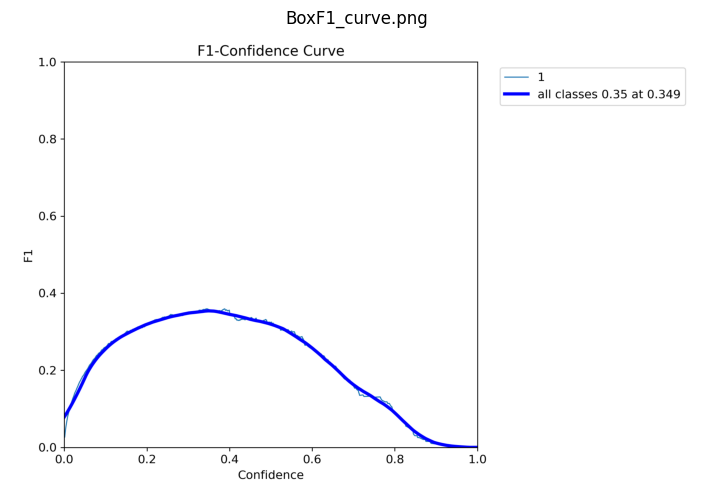

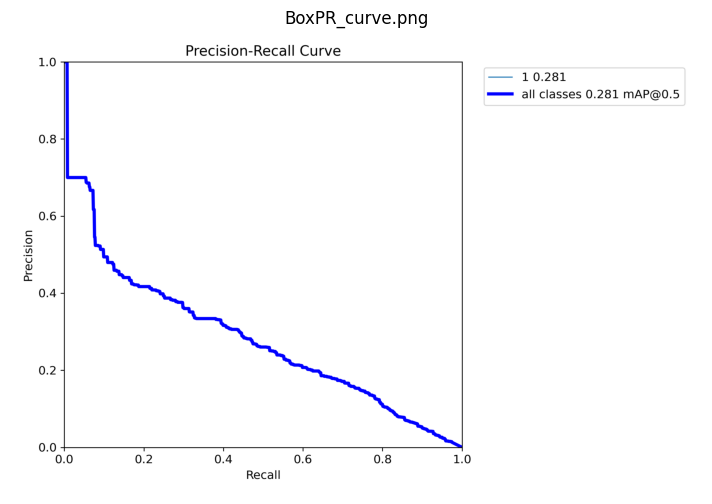

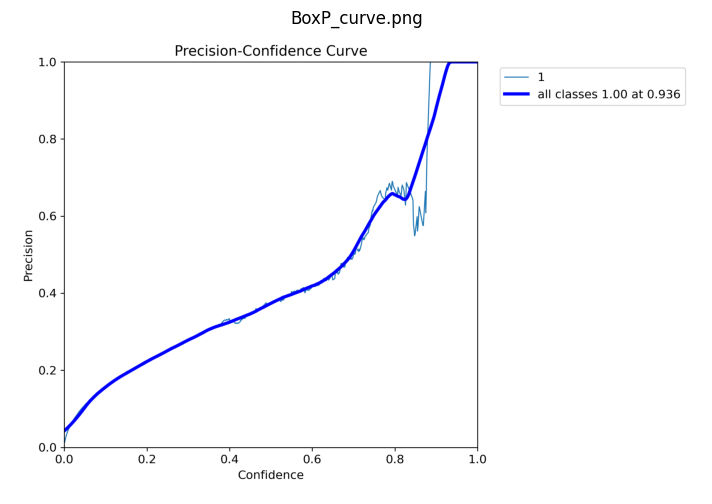

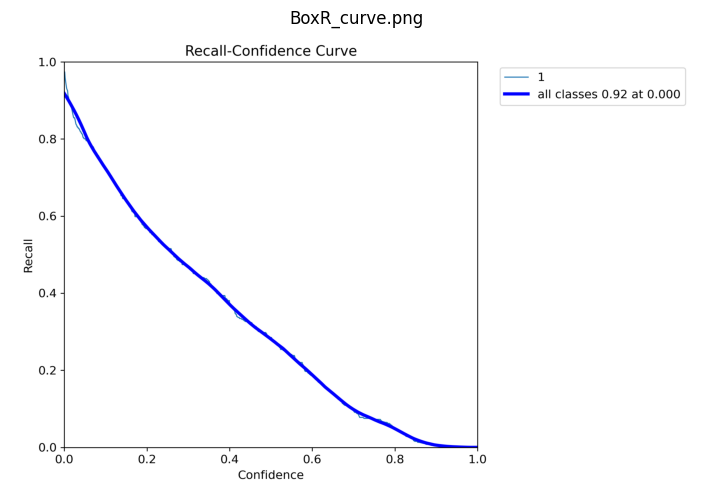

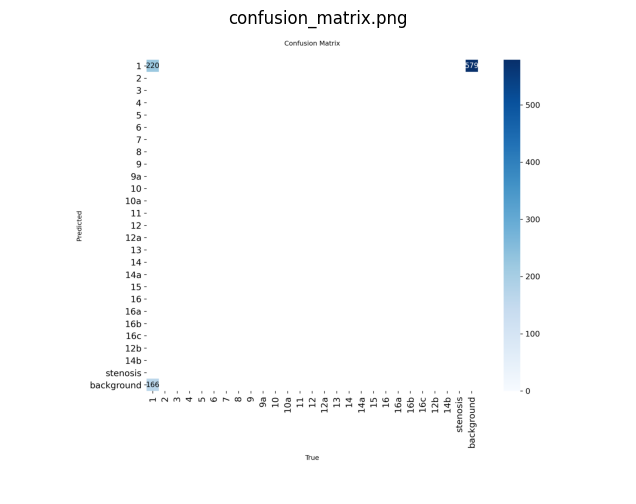

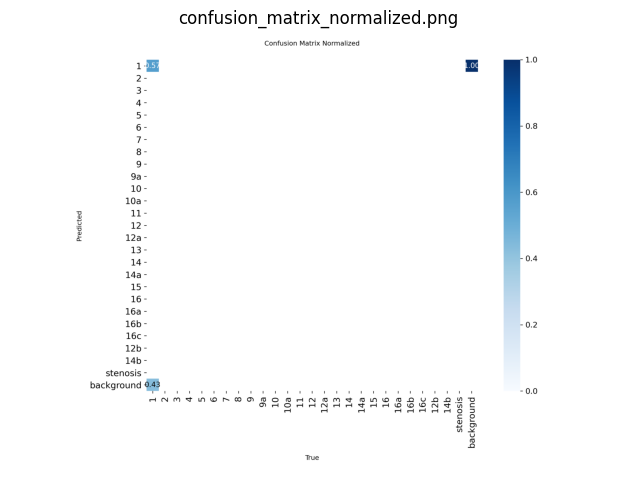

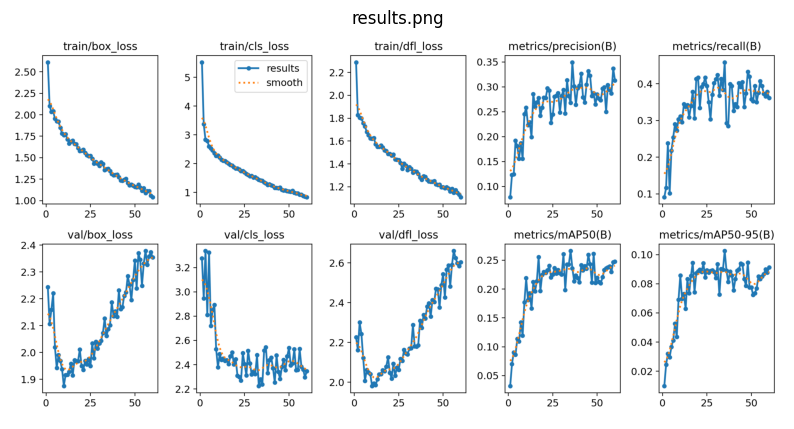

In [ ]:
# 📊 Load Training Plots (mAP, loss, etc.)
import os
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt

plot_dir = f"/content/runs/detect/session3_yolo11m2"
plot_files = sorted(glob(os.path.join(plot_dir, "*.png")))

for pf in plot_files:
    img = Image.open(pf)
    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(os.path.basename(pf))
    plt.show()


In [ ]:
import zipfile

zip_path = "/content/yolo_training_plots.zip"
with zipfile.ZipFile(zip_path, 'w') as zipf:
    for file in plot_files:
        zipf.write(file, arcname=os.path.basename(file))

print(f"✅ All plots zipped at: {zip_path}")


✅ All plots zipped at: /content/yolo_training_plots.zip


In [ ]:
from google.colab import files
files.download(zip_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>